In [21]:
%load_ext autoreload
%autoreload 1
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14, 10]


import torch
from torch.utils.data import Dataset
from retinanet.encoder import DataEncoder
import imgaug as ia
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from retinanet.retinanet import RetinaNet
from retinanet.loss import FocalLoss
from utils.pikachu_dataset import load_data_pikachu


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:

class PikachuDataset(Dataset):
    def __init__(self, anchor_areas=None):
        
        self.anchor_areas = anchor_areas
        self.train, self.val = load_data_pikachu(1)
    
        encoder = DataEncoder()
        if self.anchor_areas is not None:
            encoder.anchor_areas = self.anchor_areas  # p3 -> p7
            
        self.encoder = encoder 
        
    def __len__(self):
        return 900 #magic number thats how many images are in the pikachu dataset
        
    def __getitem__(self, i):
        try:
            b = self.train.next()
        except StopIteration:
            self.train.reset()
            b = self.train.next()
            
        image = b.data[0].asnumpy()
        bbox = b.label[0].asnumpy()[:, 0, 1:] * 256
        label = b.label[0].asnumpy()[:, 0, 0]
    
        return torch.from_numpy(image), torch.from_numpy(bbox), torch.from_numpy(label)    
    
    def collate_func(self, batch):
    

        images = [b[0][0] for b in batch]
        bbox = [b[1] for b in batch]
        labels = [b[2] for b in batch]
        
        encoded = [self.encoder.encode(bb, l, torch.Tensor([256, 256])) for bb, l in zip(bbox, labels)]
        loc_target = [l[0] for l in encoded]
        cls_target = [l[1] for l in encoded]
        

        return torch.stack(images) / 255, torch.stack(loc_target), torch.stack(cls_target)
        
def init_weights_retina(module, pi=0.02):
    if hasattr(module, 'name'):
        b = -log((1 - pi) / pi)
        if module.name == 'final_layer':
            module.bias.data.fill_(b)
        elif module.name == 'head_layer':
            module.weight.data.normal_(0, pi)
            module.bias.data.fill_(0)
                        

In [13]:
pikachu_ds =PikachuDataset()
pikachu_dl = DataLoader(pikachu_ds, batch_size=8, collate_fn=pikachu_ds.collate_func)


In [14]:
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

model = RetinaNet(1)
model = model.to(device)


model.freeze_bn()
for param in model.fpn.parameters():
    param.requires_grad = False
    

model.apply(init_weights_retina)

RetinaNet(
  (fpn): FPN(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          

In [15]:
criterion = FocalLoss(1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00004)

collect = []
for epoch in range(5):
    for b in pikachu_dl:
        optimizer.zero_grad()
        image, bounding_boxes, labels = b
        image = image.to(device)
        bounding_boxes = bounding_boxes.to(device)
        labels = labels.to(device)
        loc_pred, cls_pred = model(image)
        total_loss = criterion(loc_pred, bounding_boxes, cls_pred, labels)
        total_loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1)
        optimizer.step()
        collect.append([total_loss])
        print("total loss {}".format(total_loss))
        

/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: torch.nn.utils.clip_grad_norm is now

total loss 12754.2275390625
total loss 12660.5908203125
total loss 12591.6943359375
total loss 12498.7109375
total loss 12379.595703125
total loss 12264.1591796875
total loss 12068.216796875
total loss 11962.9521484375
total loss 11672.5185546875
total loss 11382.6201171875
total loss 11181.9423828125
total loss 10716.5625
total loss 10223.4150390625
total loss 9400.8134765625
total loss 9065.97265625
total loss 8451.275390625
total loss 7359.7890625
total loss 6479.21142578125
total loss 5805.27099609375
total loss 5289.0888671875
total loss 4062.01171875
total loss 3613.105224609375
total loss 2813.922119140625
total loss 2628.19091796875
total loss 1994.271240234375
total loss 1875.62548828125
total loss 1538.0389404296875
total loss 1353.6754150390625
total loss 1206.886474609375
total loss 1031.396728515625
total loss 1128.0714111328125
total loss 962.1911010742188
total loss 950.2083740234375
total loss 960.8135375976562
total loss 931.0064086914062
total loss 861.9110717773438
t

total loss 107.90029907226562
total loss 90.72732543945312
total loss 81.5528793334961
total loss 82.48127746582031
total loss 74.8882827758789
total loss 74.4155044555664
total loss 72.37936401367188
total loss 105.68627166748047
total loss 83.00479125976562
total loss 74.00474548339844
total loss 91.10546112060547
total loss 90.11334228515625
total loss 94.37741088867188
total loss 95.58123779296875
total loss 91.87590026855469
total loss 98.49520874023438
total loss 79.02421569824219
total loss 87.20113372802734
total loss 81.93087005615234
total loss 83.80020141601562
total loss 71.98675537109375
total loss 82.52227020263672
total loss 72.5982666015625
total loss 108.9113540649414
total loss 63.61137008666992
total loss 87.4836654663086
total loss 97.46763610839844
total loss 89.5706558227539
total loss 93.24764251708984
total loss 87.12567901611328
total loss 77.24263763427734
total loss 88.99198150634766
total loss 107.84062194824219
total loss 87.66053771972656
total loss 99.661

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6a0b7fb70>],
      dtype=object)

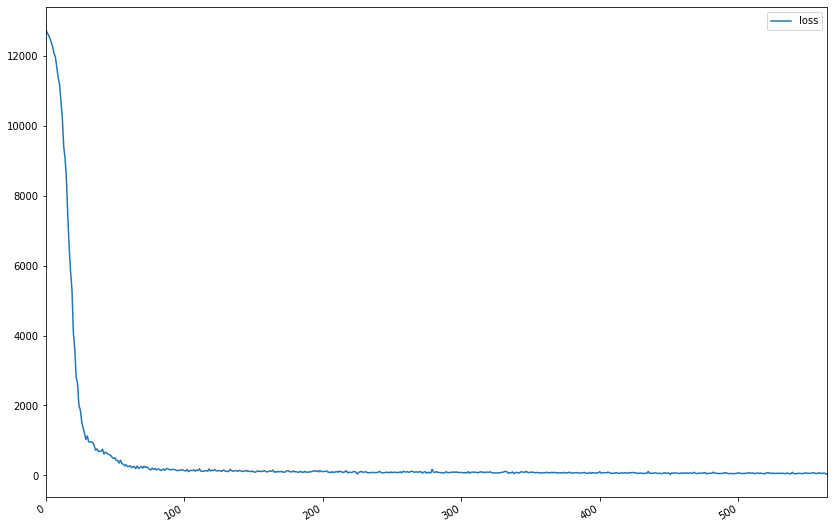

In [16]:
import pandas as pd
pd.DataFrame(collect, columns=['loss']).astype(float).plot(subplots=True)

# Visualizing Results

In [17]:
it = iter(pikachu_dl)


ValueError: only one element tensors can be converted to Python scalars

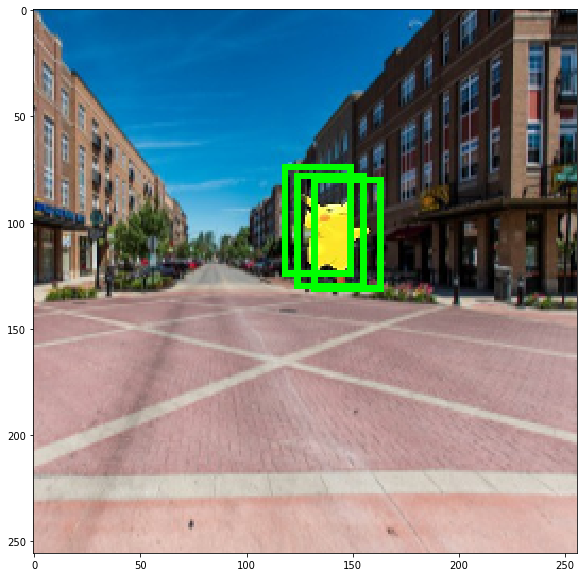

In [20]:
model.eval()
b = next(it)
i = 0
image, bounding_boxes, labels = b
loc_pred, cls_pred = model(image.cuda())


bbspred, labelpred, score  = pikachu_ds.encoder.decode(loc_pred[i].float().cpu(), 
                                                       cls_pred[i].float().cpu(), 
                                                       torch.Tensor([256, 256]).float().cpu()
                                                      )

image_to_show = np.moveaxis(image[i].detach().cpu().numpy(),0, 2)

matched_anchors_on_image = ia.BoundingBoxesOnImage(
    [ia.BoundingBox(*b) for b in bbspred.detach().cpu().numpy()], shape=(256, 256))


image_to_show = matched_anchors_on_image.draw_on_image(image_to_show, thickness=3)
plt.imshow(image_to_show)
plt.title('score ' + str(float(score)))

# Exercises

